#  Investigate sequence diversity of esterases using MMSeq

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

df_promis_esterases = pd.read_pickle('data/EnzymeCAGE_train_promiscuous_substrates_EC3p1.pkl')

In [ ]:
import sys
sys.path.append('/home/helen/enzyme-tk/enzymetk')
from enzymetk.similarity_mmseqs_step import MMseqs
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'mmseqs2/'

#df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.9', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_mmseqs2_0p9_similarity.pkl'))
#df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.6', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_mmseqs2_0p6_similarity.pkl'))
df_promis_esterases << (MMseqs(id_col, seq_col, tmp_dir=output_dir, method='cluster',  args=['--min-seq-id', '0.4', '-c', '0.8', '--cov-mode', '1']) >> Save(f'{output_dir}promiscuous_esterases_mmseqs2_0p4_similarity.pkl'))

### Embed protein sequences using ESM2

In [ ]:
import sys
from enzymetk.embedprotein_esm_step import EmbedESM
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
df_filtered = df_promis_esterases.drop_duplicates(subset='UniprotID', keep='first')
id_col = 'UniprotID'
seq_col = 'sequence'
output_dir = 'esm2/'

df_filtered << (EmbedESM(id_col, seq_col, extraction_method='mean', tmp_dir=output_dir) >> Save(f'{output_dir}promiscuous_esterases_esm2_embedded.pkl'))

In [ ]:
# Integrate mmseqs2 results into one df
df_mmseqs2_0p9 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2_0p9_similarity.pkl')
df_mmseqs2_0p6 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2_0p6_similarity.pkl')
df_mmseqs2_0p4 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2_0p4_similarity.pkl')

df_mmseqs2_0p9 = df_mmseqs2_0p9.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p9_similarity'})
df_mmseqs2_0p6 = df_mmseqs2_0p6.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p6_similarity'})
df_mmseqs2_0p4 = df_mmseqs2_0p4.rename(columns={'mmseqs_representative_cluster_seq' : 'mmseqs_representative_cluster_seq_0p4_similarity'})

df_mmseqs2 = df_mmseqs2_0p9.merge(
    df_mmseqs2_0p6[['UniprotID', 'mmseqs_representative_cluster_seq_0p6_similarity']],
    on='UniprotID', how='left')

df_mmseqs2 = df_mmseqs2.merge(
    df_mmseqs2_0p4[['UniprotID', 'mmseqs_representative_cluster_seq_0p4_similarity']],
    on='UniprotID', how='left')

#df_mmseqs2.to_pickle('/nvme2/helen/masterthesis/manuscript/mmseqs2/promiscuous_esterases_mmseqs2.pkl')

# Add esm2 embeddings to mmseqs2 pickle files
df_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_esm2_embedded.pkl')
df_mmseqs2_esm2 = df_mmseqs2.merge(df_esm2[['UniprotID', 'embedding']], on='UniprotID', how='left')
#df_mmseqs2_esm2.to_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_mmseqs2_esm2.pkl')

### Results of MMseqs2 

In [ ]:
import numpy as np
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

df_mmseqs2_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_mmseqs2_esm2.pkl')

# Number of unique clusters
num_unique_clusters = df_mmseqs2_esm2['mmseqs_representative_cluster_seq_0p9_similarity'].nunique()
print(f"Number of unique clusters: {num_unique_clusters}")

# Cluster size distribution
cluster_counts = df_mmseqs2_esm2.groupby('mmseqs_representative_cluster_seq_0p9_similarity').size()

plt.figure(figsize=(14, 7))
cluster_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Cluster Size Distribution (90% similarity)', fontsize=14)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Sequences', fontsize=12)
plt.xticks([])  # remove x-tick labels
#plt.show()

/home/helen/miniconda3/envs/promiscuity/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/helen/miniconda3/envs/promiscuity/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/helen/miniconda3/envs/promiscuity/lib/python3.13/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


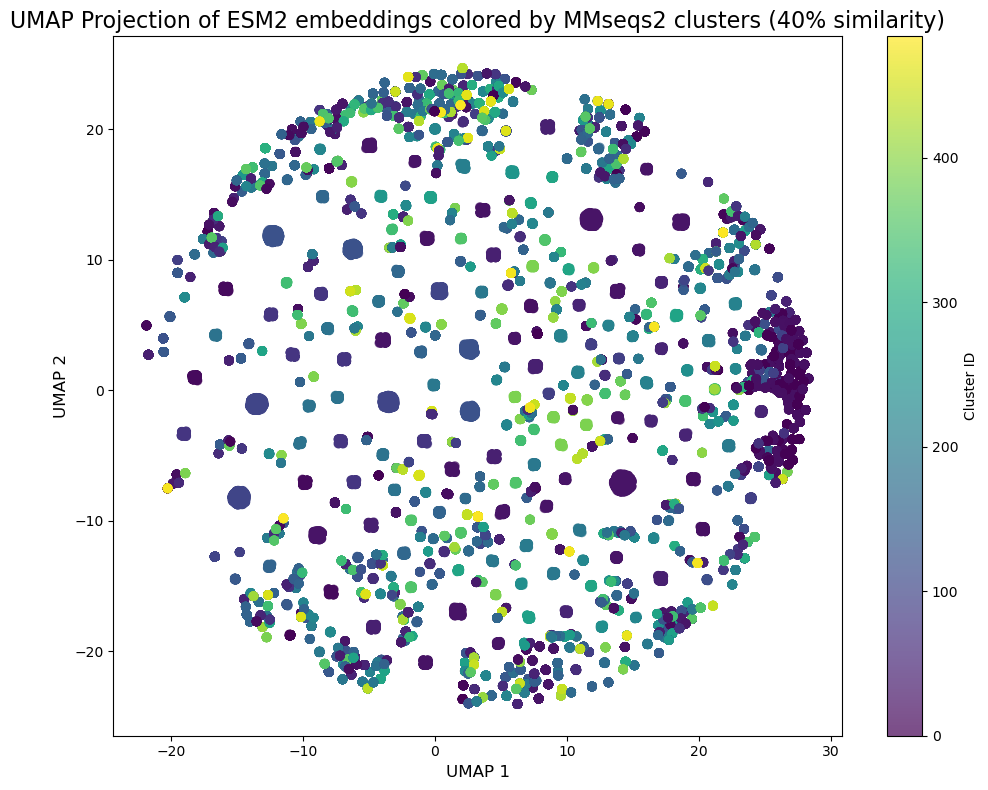

In [ ]:
# Visualize clusters using UMAP of ESM2 embeddings
df_mmseqs2_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_mmseqs2_esm2.pkl')

embeddings = np.vstack(df_mmseqs2_esm2['embedding'].to_numpy())  
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)
df_mmseqs2_esm2['UMAP1'] = reduced_embeddings[:, 0]
df_mmseqs2_esm2['UMAP2'] = reduced_embeddings[:, 1]

clusters = df_mmseqs2_esm2['mmseqs_representative_cluster_seq_0p4_similarity']
df_mmseqs2_esm2['Cluster_ID'] = pd.factorize(df_mmseqs2_esm2['mmseqs_representative_cluster_seq_0p4_similarity'])[0]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_mmseqs2_esm2['UMAP1'], df_mmseqs2_esm2['UMAP2'], c=df_mmseqs2_esm2['Cluster_ID'], cmap='viridis', alpha=0.7)
plt.title('UMAP Projection of ESM2 embeddings colored by MMseqs2 clusters (40% similarity)', fontsize=16)
plt.xlabel('UMAP 1', fontsize=12)
plt.ylabel('UMAP 2', fontsize=12)
plt.colorbar(scatter, label='Cluster ID')
plt.tight_layout()
plt.show()

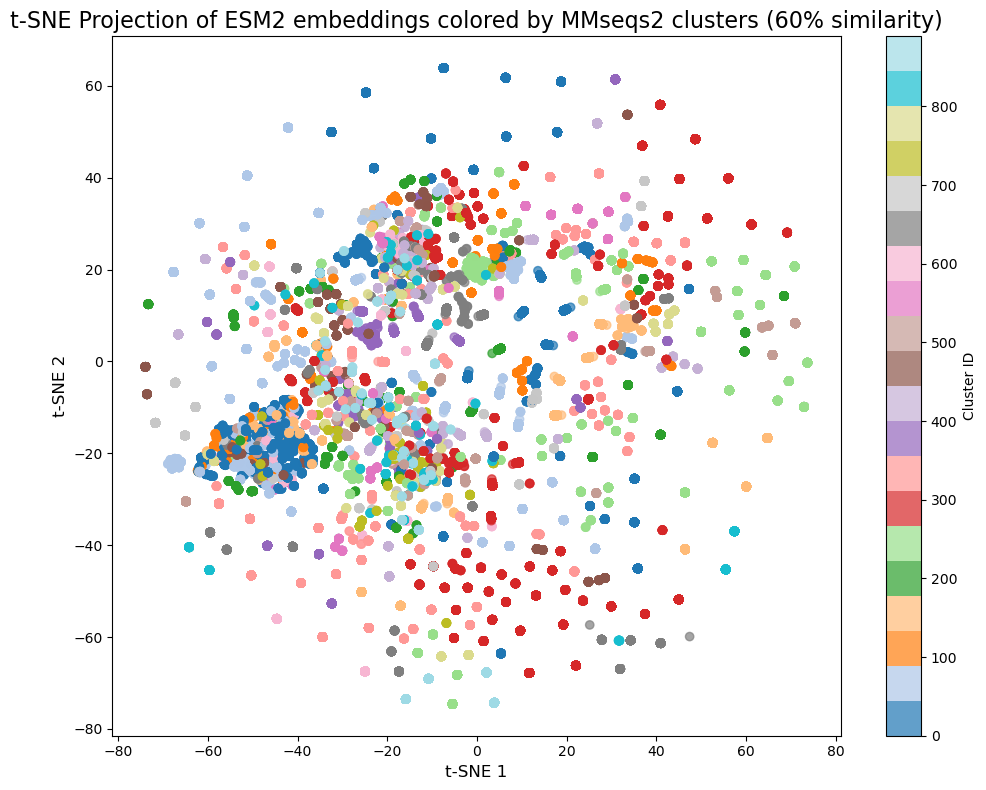

In [ ]:
from sklearn.manifold import TSNE

# Visualize clusters using t-SNE of ESM2 embeddings
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

df_mmseqs2_esm2['TSNE1'] = tsne_results[:, 0]
df_mmseqs2_esm2['TSNE2'] = tsne_results[:, 1]

# Assign Cluster IDs 
clusters = df_mmseqs2_esm2['mmseqs_representative_cluster_seq_0p9_similarity']
df_mmseqs2_esm2['Cluster_ID'] = pd.factorize(clusters)[0]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_mmseqs2_esm2['TSNE1'], df_mmseqs2_esm2['TSNE2'],
                      c=df_mmseqs2_esm2['Cluster_ID'], cmap='viridis', alpha=0.7)
plt.title('t-SNE Projection of ESM2 embeddings colored by MMseqs2 clusters (90% similarity)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.colorbar(scatter, label='Cluster ID')
plt.tight_layout()
plt.show()

### Sequence length distribution

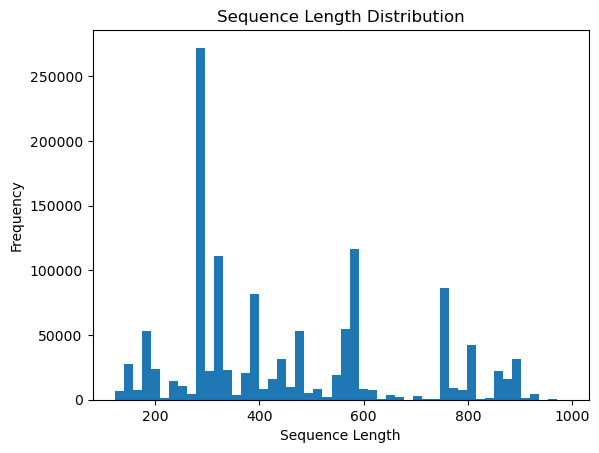

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_sequence_length_histogram_from_df(df, sequence_column="sequence"):

    sequence_lengths = df[sequence_column].apply(len)
    plt.hist(sequence_lengths, bins=50)  # Adjust the number of bins as needed
    plt.xlabel("Sequence Length")
    plt.ylabel("Frequency")
    plt.title("Sequence Length Distribution")
    plt.show()

df_mmseqs2_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_mmseqs2_esm2.pkl')
plot_sequence_length_histogram_from_df(df_mmseqs2_esm2)

### Characterizing substrate landscape

In [ ]:
# Embed substrates using unimol

from enzymetk.embedchem_unimol_step import UniMol
from enzymetk.save_step import Save
import pandas as pd

# run in enzymetk environemnt
df_mmseqs2_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_mmseqs2_esm2.pkl')
smiles_col = 'substrates_split'
output_dir = 'unimol/'

df_mmseqs2_esm2 << (UniMol(smiles_col) >> Save(f'{output_dir}promiscuous_esterases_unimol_embedded.pkl'))

2025-05-27 10:40:55 | unimol_tools/models/unimolv2.py | 161 | INFO | Uni-Mol Tools | Loading pretrained weights from /home/helen/miniconda3/envs/enzymetk/lib/python3.11/site-packages/unimol_tools/weights/modelzoo/164M/checkpoint.pt
2025-05-27 10:40:56 | unimol_tools/data/conformer.py | 437 | INFO | Uni-Mol Tools | Start generating conformers...
1it [00:00,  1.82it/s]
2025-05-27 10:40:57 | unimol_tools/data/conformer.py | 452 | INFO | Uni-Mol Tools | Succeeded in generating conformers for 100.00% of molecules.
2025-05-27 10:40:57 | unimol_tools/data/conformer.py | 469 | INFO | Uni-Mol Tools | Succeeded in generating 3d conformers for 100.00% of molecules.
2025-05-27 10:40:57 | unimol_tools/tasks/trainer.py | 78 | INFO | Uni-Mol Tools | Number of GPUs available: 2
2025-05-27 10:40:57 | unimol_tools/tasks/trainer.py | 98 | INFO | Uni-Mol Tools | Using single GPU.
100%|██████████| 1/1 [00:00<00:00, 26.30it/s]
2025-05-27 10:40:57 | unimol_tools/data/conformer.py | 437 | INFO | Uni-Mol Tools

,UniprotID,RHEA_ID,DIRECTION,MASTER_ID,SMILES,EC number,CANO_RXN_SMILES,sequence,reverse_template,n_seq,...,substrates,products,number_substrates,number_products,substrates_split,mmseqs_representative_cluster_seq_0p9_similarity,mmseqs_representative_cluster_seq_0p6_similarity,mmseqs_representative_cluster_seq_0p4_similarity,embedding,unimol_repr
0,A0A023W421,53744,UN,53744,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,3.1.1.96,*P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-1.8970382, 12.077213, -20.261026, -1.446667..."
1,A0A023W421,53744,UN,53744,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,3.1.1.96,*P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-1.8970382, 12.077213, -20.261026, -1.446667..."
2,A0A023W421,53744,UN,53744,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,3.1.1.96,*P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-1.8970382, 12.077213, -20.261026, -1.446667..."
3,A0A023W421,53744,UN,53744,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,3.1.1.96,*P(=O)(O)OC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-1.8970382, 12.077213, -20.261026, -1.446667..."
4,A0A023W421,13953,UN,13953,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,3.1.1.96,*[C@@H](N)C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-3.1971025, 11.533536, -20.357761, -1.748606..."
5,A0A023W421,13953,UN,13953,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,3.1.1.96,*[C@@H](N)C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-3.1971025, 11.533536, -20.357761, -1.748606..."
6,A0A023W421,13953,UN,13953,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,3.1.1.96,*[C@@H](N)C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,MKLVVQRVTDASVTVDGAVAGRIGPGIMALVGVTHEDTEEDAAYLA...,[C:4]-[C;H0;D3;+0:3](-[O-;H0;D1:6])=[O;D1;H0:5...,147,...,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,*P(=O)([O-])OC[C@H]1O[C@@H](N2C=NC3=C(N)N=CN=C...,1,3,*[C@@H]([NH3+])C(=O)O[C@H]1[C@@H](O)[C@H](N2C=...,A0A023W421,A9WE39,Q2T9V8,"[0.02359803, -0.0028808287, 0.0125321625, 0.00...","[[-3.19

In [ ]:
# Add UniMol embeddings to mmseqs2 pickle files
df_esm2 = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_esm2_embedded.pkl')
df_mmseqs2_esm2 = df_mmseqs2.merge(df_esm2[['UniprotID', 'embedding']], on='UniprotID', how='left')
#df_mmseqs2_esm2.to_pickle('/nvme2/helen/masterthesis/manuscript/esm2/promiscuous_esterases_mmseqs2_esm2.pkl')

In [ ]:
# Calculate molecular properties of substrates

from rdkit import Chem
from rdkit.Chem import Descriptors, rdPartialCharges, rdMolDescriptors
import pubchempy as pcp
from tqdm import tqdm
from collections import defaultdict

def get_longest_aliphatic_chain_length(mol):
    """
    Returns the length of the longest aliphatic (non-aromatic, non-ring) carbon chain.
    """
    from rdkit.Chem.rdmolops import GetShortestPath

    max_chain = 0
    atoms = [atom for atom in mol.GetAtoms() if atom.GetSymbol() == 'C' and not atom.GetIsAromatic() and not atom.IsInRing()]
    for i in range(len(atoms)):
        for j in range(i + 1, len(atoms)):
            path = GetShortestPath(mol, atoms[i].GetIdx(), atoms[j].GetIdx())
            # Ensure all atoms in the path are eligible (non-ring, non-aromatic C)
            if all(mol.GetAtomWithIdx(idx).GetSymbol() == 'C' and
                   not mol.GetAtomWithIdx(idx).GetIsAromatic() and
                   not mol.GetAtomWithIdx(idx).IsInRing()
                   for idx in path):
                max_chain = max(max_chain, len(path))
    return max_chain

def get_partialcharge_carbonyl(mol):
    """
    Returns the minimum Gasteiger partial charge among ester carbonyl carbons in the molecule.
    """
    # SMARTS pattern to match ester carbonyl carbon
    ester_carbonyl_smarts = Chem.MolFromSmarts('[CX3](=O)[OX2H0][C]')
    matches = mol.GetSubstructMatches(ester_carbonyl_smarts)

    if not matches:
        return None  # No ester group found

    # Get the index of the carbonyl carbon (first atom in the pattern)
    carbonyl_c_indices = [match[0] for match in matches]

    # Extract partial charges
    charges = []
    for idx in carbonyl_c_indices:
        atom = mol.GetAtomWithIdx(idx)
        charge = float(atom.GetProp('_GasteigerCharge'))
        charges.append(charge)

    return min(charges)  # Most electrophilic carbonyl (lowest charge)

def get_molecular_properties(smiles, include_name=False):
    # Including the name makes it wayy slower.
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Invalid SMILES"

    # Compute Gasteiger charges
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol)

    # Count halogen atoms
    halogen_symbols = ['F', 'Cl', 'Br', 'I']
    halogen_count = sum(1 for atom in mol.GetAtoms() if atom.GetSymbol() in halogen_symbols)

    # Extract properties
    properties = {
        "MolWt": Descriptors.MolWt(mol),
        "TPSA": Descriptors.TPSA(mol),
        "MolLogP": Descriptors.MolLogP(mol),
        "HeavyAtoms":  Descriptors.HeavyAtomCount(mol), 
        "HydrogenAcceptors": Descriptors.NumHAcceptors(mol), 
        "HydrogenDonors": Descriptors.NumHDonors(mol), 
        "MaxPartialCharge": float(max(atom.GetProp("_GasteigerCharge") for atom in mol.GetAtoms())),
        "MinPartialCharge": float(min(atom.GetProp("_GasteigerCharge") for atom in mol.GetAtoms())),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol), 
        'FractionCSP3': Descriptors.FractionCSP3(mol),
        'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol),
        'NumAliphaticRings': rdMolDescriptors.CalcNumAliphaticRings(mol),
        'NumAromaticAtoms': sum(1 for a in mol.GetAtoms() if a.GetIsAromatic()),
        'TotalAtoms': mol.GetNumAtoms(),
        'AromaticAtomFraction': sum(1 for a in mol.GetAtoms() if a.GetIsAromatic()) / mol.GetNumAtoms(),
        'RingCount': Descriptors.RingCount(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'Kappa1': Descriptors.Kappa1(mol),
        'Kappa2': Descriptors.Kappa2(mol),
        'Kappa3': Descriptors.Kappa3(mol),
        'HallKierAlpha': Descriptors.HallKierAlpha(mol),
        'LabuteASA': rdMolDescriptors.CalcLabuteASA(mol),
        "NumHalogenAtoms": halogen_count, 
        "LongestAliphaticChain": get_longest_aliphatic_chain_length(mol), 
        'PartialChargeCarbonyl' : get_partialcharge_carbonyl(mol)
    }
    # Get compound name from PubChem
    if include_name:
        try:
            compound = pcp.get_compounds(smiles, namespace='smiles')[0]
            properties["CompoundName"] = compound.iupac_name
        except IndexError:
            properties["CompoundName"] = "Not Found"

    return properties

properties_df = combined_df['SMILES'].apply(get_molecular_properties).apply(pd.Series)
combined_df = pd.concat([combined_df, properties_df], axis=1)

In [ ]:
# Visualizing diversity of substrates


# Also try: Color-coding by other substrate properties


In [ ]:
# Correlation of substrates embeddings with MMseqs2 clusters

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_substrate_embeddings_by_cluster(df, embedding_column='unimol_repr', cluster_column='mmseqs_representative_cluster_seq_0p9_similarity', reduction='pca'):
    """
    Reduces the dimensionality of substrate embeddings and plots them, colored by MMseqs2 cluster.
    """
    processed_embeddings = []
    valid_indices = []
    for i, emb_list in enumerate(df[embedding_column]):
        if isinstance(emb_list, list) and len(emb_list) == 1:
            embedding = emb_list[0]
            if isinstance(embedding, np.ndarray) and embedding.size > 0:
                processed_embeddings.append(embedding.flatten())
                valid_indices.append(i)
            else:
                print(f"Warning: Row {i}: Invalid inner embedding: {embedding}")
        else:
            print(f"Warning: Row {i}: Unexpected embedding format: {emb_list}")

    if not processed_embeddings:
        print("No valid embeddings found for plotting.")
        return

    valid_embeddings = np.array(processed_embeddings)
    df_filtered = df.iloc[valid_indices].copy()
    labels_categorical = df_filtered[cluster_column].astype('category')
    labels_numerical = labels_categorical.cat.codes
    categories = labels_categorical.cat.categories.tolist()

    if valid_embeddings.ndim < 2 or valid_embeddings.shape[1] < 2:
        print(f"Valid embeddings have shape {valid_embeddings.shape}, cannot reliably reduce to 2D for plotting.")
        return

    n_components = 2
    reduced_embeddings = None

    if reduction.lower() == 'pca':
        print("Applying PCA for dimensionality reduction...")
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(valid_embeddings)
        title = f'Substrate Embeddings (PCA) by {cluster_column}'
    elif reduction.lower() == 'tsne':
        print("Applying t-SNE for dimensionality reduction...")
        tsne = TSNE(n_components=n_components, random_state=42, n_iter=300, verbose=0)
        reduced_embeddings = tsne.fit_transform(valid_embeddings)
        title = f'Substrate Embeddings (t-SNE) by {cluster_column}'

    if reduced_embeddings is not None:
        jitter = 0.001 * np.random.randn(*reduced_embeddings.shape)  # Small random noise
        reduced_embeddings_jittered = reduced_embeddings + jitter
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(reduced_embeddings_jittered[:, 0], reduced_embeddings_jittered[:, 1], c=labels_numerical, cmap='viridis', alpha=0.5, s=5)
        plt.xlabel(f'{reduction.upper()} Component 1')
        plt.ylabel(f'{reduction.upper()} Component 2')
        plt.title(title)
        plt.legend(handles=scatter.legend_elements()[0], labels=categories, title=df_filtered[cluster_column].unique().tolist())
        plt.colorbar(scatter, ticks=np.arange(len(categories)), label='Cluster Index')
        plt.show()

df = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/unimol/promiscuous_esterases_unimol_embedded_TEST.pkl')

visualize_substrate_embeddings_by_cluster(df,  cluster_column='mmseqs_representative_cluster_seq_0p9_similarity')
visualize_substrate_embeddings_by_cluster(df,  cluster_column='mmseqs_representative_cluster_seq_0p6_similarity')
visualize_substrate_embeddings_by_cluster(df,  cluster_column='mmseqs_representative_cluster_seq_0p4_similarity')


In [30]:
# Qualitative analysis of substrate similarity within MMseqs2 clusters

import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean

def quantitative_substrate_analysis(df, embedding_column='unimol_repr', cluster_column='mmseqs_representative_cluster_seq_0p9_similarity'):
    """
    Calculates the centroid and variance of substrate embeddings per MMseqs2 cluster
    and the distances between cluster centroids.
    """
    grouped = df.groupby(cluster_column)[embedding_column].apply(list)

    cluster_centroids = {}
    cluster_variances = {}

    print("--- Centroid and Variance per Cluster ---")
    for cluster, embeddings_list in grouped.items():
        if embeddings_list:
            embeddings_array = np.array(embeddings_list)
            centroid = np.mean(embeddings_array, axis=0)
            variance = np.mean(np.var(embeddings_array, axis=0)) # Average of variances along each dimension
            cluster_centroids[cluster] = centroid
            cluster_variances[cluster] = variance
            print(f"Cluster {cluster}:")
            print(f"  Centroid (first 5 elements): {centroid[:5]}...")
            print(f"  Average Variance: {variance:.4f}")
        else:
            print(f"Cluster {cluster}: No substrate embeddings found.")

    print("\n--- Distances Between Cluster Centroids ---")
    clusters = list(cluster_centroids.keys())
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            if cluster1 in cluster_centroids and cluster2 in cluster_centroids:
                dist = euclidean(cluster_centroids[cluster1], cluster_centroids[cluster2])
                print(f"Distance between centroid of Cluster {cluster1} and Cluster {cluster2}: {dist:.4f}")

df = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/unimol/promiscuous_esterases_unimol_embedded_TEST.pkl')
quantitative_substrate_analysis(df, cluster_column='mmseqs_representative_cluster_seq_0p9_similarity')

# The centroid gives you a central "average" UniMol embedding for the substrates associated with each enzyme cluster.
# The average variance gives you a measure of how spread out the substrate embeddings are within each cluster. 
# A lower variance suggests that the substrates of enzymes in that cluster are more structurally similar to each other (according to UniMol).

# The Euclidean distance  between the centroids of two different clusters gives you an idea 
# of how structurally similar the average preferred substrates are for those two enzyme clusters. 
# Smaller distances suggest more similar average substrate preferences.

--- Centroid and Variance per Cluster ---
Cluster A0A023W421:
  Centroid (first 5 elements): [[-2.54707050e+00  1.18053751e+01 -2.03093929e+01 -1.59763646e+00
  -9.75720787e+00  1.39449984e-01 -8.38579845e+00 -9.12959290e+00
  -2.03531337e+00 -2.38459778e+00 -2.01102219e+01 -6.32762623e+00
  -8.99402809e+00  3.62260795e+00 -1.16618462e+01 -4.61213112e+00
  -7.29822445e+00  2.45127439e+00 -1.05761290e-01  1.17196474e+01
  -5.39835405e+00  2.57436633e+00 -1.14469423e+01 -1.37746251e+00
  -5.24600804e-01 -6.40073729e+00 -5.63433588e-01 -2.65195036e+00
   5.37526798e+00  1.07085676e+01  6.29438353e+00 -7.85881424e+00
   5.84036875e+00  3.20553660e-01 -1.27162895e+01 -4.86495793e-01
  -2.67003202e+00  2.13735151e+00  1.05675554e+00  1.28154478e+01
  -1.06493931e+01  1.76362085e+00  3.49699068e+00 -1.50189867e+01
  -1.36249428e+01 -9.09910107e+00 -6.00629598e-02 -4.22328472e+00
  -1.47808409e+01  6.39664793e+00  1.30138435e+01 -1.07573185e+01
  -1.07391858e+00 -1.41583490e+00  6.73051298e-01

ValueError: Input vector should be 1-D.

In [31]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean

def quantitative_substrate_analysis_fixed(df, embedding_column='unimol_repr', cluster_column='mmseqs_representative_cluster_seq_0p9_similarity'):
    """
    Calculates the centroid and variance of substrate embeddings per MMseqs2 cluster
    and the distances between cluster centroids (fixed for embedding structure).
    """
    grouped = df.groupby(cluster_column)[embedding_column].apply(list)

    cluster_centroids = {}
    cluster_variances = {}

    print("--- Centroid and Variance per Cluster ---")
    for cluster, embeddings_list in grouped.items():
        if embeddings_list:
            # Ensure each embedding is treated as a vector
            embeddings_array = np.array([np.array(emb).flatten() for emb in embeddings_list])
            if embeddings_array.ndim > 1 and embeddings_array.shape[1] > 0:
                centroid = np.mean(embeddings_array, axis=0)
                variance = np.mean(np.var(embeddings_array, axis=0)) # Average of variances along each dimension
                cluster_centroids[cluster] = centroid
                cluster_variances[cluster] = variance
                print(f"Cluster {cluster}:")
                print(f"  Centroid (first 5 elements): {centroid[:5]}...")
                print(f"  Average Variance: {variance:.4f}")
            else:
                print(f"Cluster {cluster}: Inconsistent or 1D embeddings found.")
        else:
            print(f"Cluster {cluster}: No substrate embeddings found.")

    print("\n--- Distances Between Cluster Centroids ---")
    clusters = list(cluster_centroids.keys())
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            cluster1 = clusters[i]
            cluster2 = clusters[j]
            if cluster1 in cluster_centroids and cluster2 in cluster_centroids:
                dist = euclidean(cluster_centroids[cluster1], cluster_centroids[cluster2])
                print(f"Distance between centroid of Cluster {cluster1} and Cluster {cluster2}: {dist:.4f}")

df = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/unimol/promiscuous_esterases_unimol_embedded_TEST.pkl')
quantitative_substrate_analysis_fixed(df, cluster_column='mmseqs_representative_cluster_seq_0p9_similarity')

--- Centroid and Variance per Cluster ---
Cluster A0A023W421:
  Centroid (first 5 elements): [ -2.5470705  11.805375  -20.309393   -1.5976365  -9.757208 ]...
  Average Variance: 0.1345
Cluster A0A0G2JXT6:
  Centroid (first 5 elements): [ -3.5033367  12.379314  -18.272009   -5.124303  -11.55742  ]...
  Average Variance: 4.3404

--- Distances Between Cluster Centroids ---
Distance between centroid of Cluster A0A023W421 and Cluster A0A0G2JXT6: 53.4367


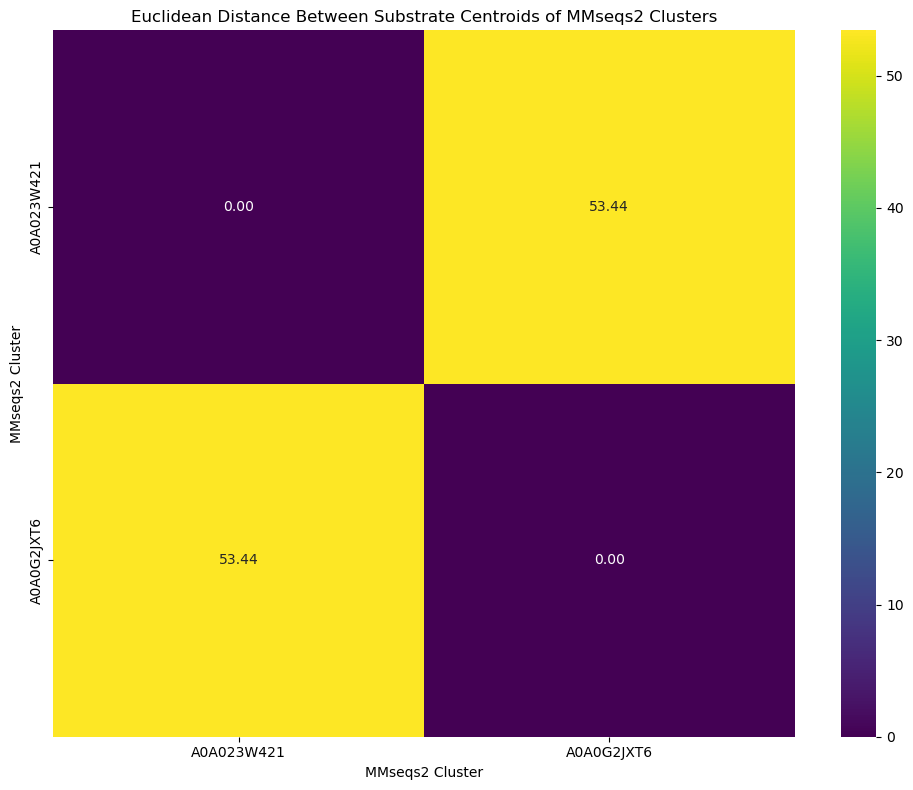

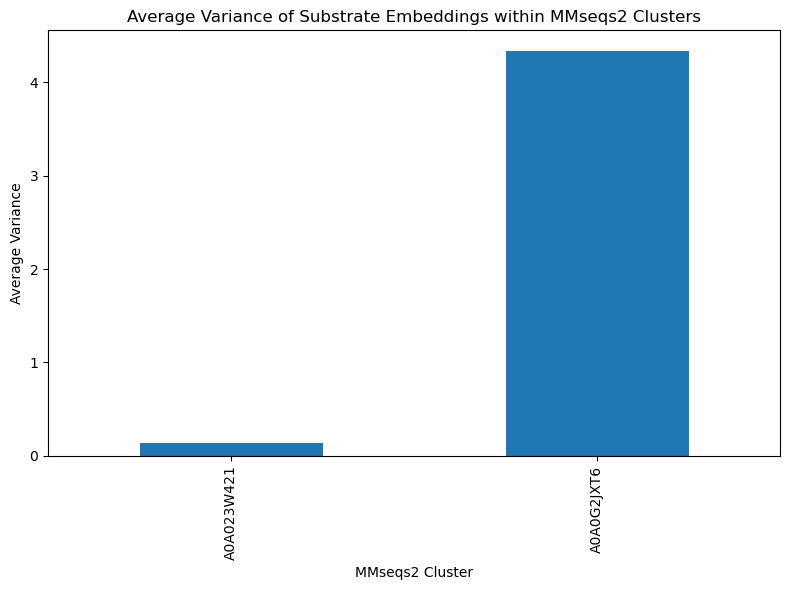

In [32]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import seaborn as sns

def quantitative_substrate_analysis_for_viz(df, embedding_column='unimol_repr', cluster_column='mmseqs_representative_cluster_seq_0p9_similarity'):
    """
    Calculates centroid distances and variances for visualization.
    """
    grouped = df.groupby(cluster_column)[embedding_column].apply(list)
    cluster_centroids = {}
    cluster_variances = {}
    for cluster, embeddings_list in grouped.items():
        if embeddings_list:
            embeddings_array = np.array([np.array(emb).flatten() for emb in embeddings_list])
            if embeddings_array.ndim > 1 and embeddings_array.shape[1] > 0:
                cluster_centroids[cluster] = np.mean(embeddings_array, axis=0)
                cluster_variances[cluster] = np.mean(np.var(embeddings_array, axis=0))
            else:
                cluster_variances[cluster] = np.nan
        else:
            cluster_variances[cluster] = np.nan

    clusters = list(cluster_centroids.keys())
    distance_matrix = pd.DataFrame(index=clusters, columns=clusters)
    for i, cluster1 in enumerate(clusters):
        for j, cluster2 in enumerate(clusters):
            if cluster1 in cluster_centroids and cluster2 in cluster_centroids:
                dist = euclidean(cluster_centroids[cluster1], cluster_centroids[cluster2])
                distance_matrix.loc[cluster1, cluster2] = dist
            else:
                distance_matrix.loc[cluster1, cluster2] = np.nan

    variance_df = pd.Series(cluster_variances, name='Average Variance')
    return distance_matrix, variance_df

df = pd.read_pickle('/nvme2/helen/masterthesis/manuscript/unimol/promiscuous_esterases_unimol_embedded_TEST.pkl')
distance_matrix, variance_df = quantitative_substrate_analysis_for_viz(df, cluster_column='mmseqs_representative_cluster_seq_0p9_similarity')

# 1. Heatmap of Centroid Distances
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix.astype(float), annot=True, cmap='viridis', fmt=".2f")
plt.title('Euclidean Distance Between Substrate Centroids of MMseqs2 Clusters')
plt.xlabel('MMseqs2 Cluster')
plt.ylabel('MMseqs2 Cluster')
plt.tight_layout()
plt.show()

# 2. Bar Chart of Cluster Variance
plt.figure(figsize=(8, 6))
variance_df.sort_values().plot(kind='bar')
plt.title('Average Variance of Substrate Embeddings within MMseqs2 Clusters')
plt.xlabel('MMseqs2 Cluster')
plt.ylabel('Average Variance')
plt.tight_layout()
plt.show()

Visualization:

Dimensionality Reduction: Use techniques like PCA or t-SNE to reduce the high-dimensional UniMol embeddings to 2 or 3 dimensions and then plot them. Color-code the points by the MMseqs2 cluster of the enzyme that uses that substrate. If substrates of enzymes within the same cluster tend to group together in the embedding space, it suggests a correlation.
You could also color-code by other substrate properties if you have them.

Quantitative Analysis:

Calculate the average or centroid embedding for the substrates associated with each MMseqs2 cluster. Then, compare the distances between these centroid embeddings of different clusters. Smaller distances might indicate that the clusters of enzymes prefer structurally similar substrates.
For each cluster, calculate the variance or spread of the substrate embeddings. A lower variance within a cluster might suggest that the enzymes in that cluster prefer a more structurally homogeneous set of substrates.